## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
for img, label in train_loader:
    print(img.shape)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


In [6]:
# Function for plotting losses -- we need it to see if the model is overfitted
def plot_losses(train_loss, test_loss):
  plt.figure(figsize=(10, 7))
      
  plt.title("Test and Training losses")
  plt.xlabel("#iteration")
  plt.ylabel("loss")
  plt.plot(test_loss, 'b', label='test loss')
  plt.plot(train_loss, 'r', label='train loss')
  plt.legend()
  plt.show()


In [7]:
def plot_accuracy(train_acc, test_acc):
  plt.figure(figsize=(10, 7))
      
  plt.title("Test and Training accuracy")
  plt.xlabel("#iteration")
  plt.ylabel("accuracy")
  plt.plot(test_acc, 'b', label='test accuracy')
  plt.plot(train_acc, 'r', label='train accuracy')
  plt.legend()
  plt.show()

In [8]:
# Runs the model on the train dataset
def test(model, loss_func):
  test_accuracy = 0
  test_loss = 0
  for test_data, test_target in test_loader:
    test_data = test_data.to(device)
    test_target = test_target.to(device)
    model_out = model(test_data).to(device)
    test_accuracy += (torch.eq(test_target, torch.argmax(model_out, -1)).float().mean())
    test_loss += loss_func(model_out, test_target).mean().detach().cpu().numpy()
  test_accuracy /= len(test_loader)
  test_loss /= len(test_loader)

  return {'acc': test_accuracy, 'loss': test_loss}

In [9]:
# Just prints some stuff
def pretty_print(train_accuracy, test_accuracy, train_loss, test_loss): 
  print('Train accuracy: {}'.format(train_accuracy))
  print('Test accuracy: {}'.format(test_accuracy))
  print('Train loss: {}'.format(train_loss))
  print('Test loss: {}'.format(test_loss))

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [23]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        some_const = 700
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, some_const),
            nn.LeakyReLU(),
            nn.Linear(some_const, some_const),
            nn.LeakyReLU(),
            nn.Linear(some_const, num_classes)
        )
        
    def forward(self, inp):       
        return self.model(inp)

In [27]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 700]         549,500
         LeakyReLU-3                  [-1, 700]               0
            Linear-4                  [-1, 700]         490,700
         LeakyReLU-5                  [-1, 700]               0
            Linear-6                   [-1, 10]           7,010
Total params: 1,047,210
Trainable params: 1,047,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 3.99
Estimated Total Size (MB): 4.03
----------------------------------------------------------------


Your experiments come here:

In [28]:
model = TinyNeuralNetwork().to(device)
# Setting some training parameters 
learning_rate = 1e-2
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

epochs = 30
log_interval=100
train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []
train_accuracy = 0
train_loss = 0

Train Epoch: 0 [0/60000 (0%)] tLoss: 2.294886
Train Epoch: 0 [12800/60000 (21%)] tLoss: 0.915235
Train Epoch: 0 [25600/60000 (43%)] tLoss: 0.621294
Train Epoch: 0 [38400/60000 (64%)] tLoss: 0.594224
Train Epoch: 0 [51200/60000 (85%)] tLoss: 0.463191
Train accuracy: 0.7351468205451965
Test accuracy: 0.81982421875
Train loss: 0.7747292690821039
Test loss: 0.5088535830378532
Train Epoch: 1 [0/60000 (0%)] tLoss: 0.446335
Train Epoch: 1 [12800/60000 (21%)] tLoss: 0.468876
Train Epoch: 1 [25600/60000 (43%)] tLoss: 0.526899
Train Epoch: 1 [38400/60000 (64%)] tLoss: 0.527344
Train Epoch: 1 [51200/60000 (85%)] tLoss: 0.550963
Train accuracy: 0.8352323770523071
Test accuracy: 0.8394531607627869
Train loss: 0.4678099773444744
Test loss: 0.4535946898162365
Train Epoch: 2 [0/60000 (0%)] tLoss: 0.349897
Train Epoch: 2 [12800/60000 (21%)] tLoss: 0.357908
Train Epoch: 2 [25600/60000 (43%)] tLoss: 0.423547
Train Epoch: 2 [38400/60000 (64%)] tLoss: 0.414327
Train Epoch: 2 [51200/60000 (85%)] tLoss: 0.49

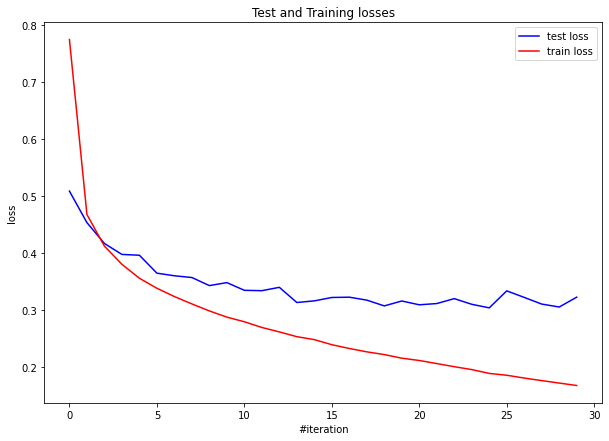

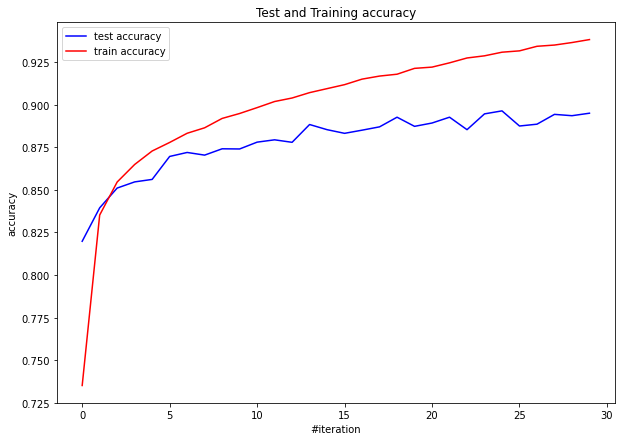

In [29]:
# Main training / testing loop 
for epoch in range(epochs):

  # Training
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    opt.zero_grad()
    model_out = model(data).to(device)
    train_accuracy += (torch.eq(target, torch.argmax(model_out, -1)).float().mean())
    loss = loss_func(model_out, target)
    train_loss += loss.mean().detach().cpu().numpy()
    loss.backward()
    opt.step()

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)] tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                          100. * batch_idx / len(train_loader), loss.data))
  
  train_accuracy /= len(train_loader)
  train_loss /= len(train_loader)
  train_loss_history.append(train_loss)
  train_acc_history.append(train_accuracy)
  
  # Testing 
  test_params = test(model, loss_func)
  test_accuracy = test_params['acc']
  test_loss = test_params['loss']
  test_loss_history.append(test_loss)
  test_acc_history.append(test_accuracy)
  
  pretty_print(train_accuracy, test_accuracy, train_loss, test_loss)

  train_accuracy = 0 
  test_accuracy = 0

plot_losses(train_loss_history, test_loss_history)
plot_accuracy(train_acc_history, test_acc_history) 

**We achieved accuracy about 0.89 on the test dataset. Woo-hoo!**

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [14]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        some_big_const = 1500
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, some_big_const), 
            nn.ReLU(), 
            nn.Linear(some_big_const, some_big_const), 
            #nn.ReLU(), 
            #nn.Linear(input_shape, input_shape), 
            nn.ReLU(), 
            nn.Linear(some_big_const, num_classes)
        )
        
    def forward(self, inp):       
        return self.model(inp)


In [15]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1500]       1,177,500
              ReLU-3                 [-1, 1500]               0
            Linear-4                 [-1, 1500]       2,251,500
              ReLU-5                 [-1, 1500]               0
            Linear-6                   [-1, 10]          15,010
Total params: 3,444,010
Trainable params: 3,444,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 13.14
Estimated Total Size (MB): 13.19
----------------------------------------------------------------


In [17]:
model =  OverfittingNeuralNetwork().to(device)
# Setting some training parameters
learning_rate = 1e-2
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

epochs = 70
log_interval=100
train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []
train_accuracy = 0
train_loss = 0

Train Epoch: 0 [0/60000 (0%)] tLoss: 2.308022
Train Epoch: 0 [12800/60000 (21%)] tLoss: 0.700722
Train Epoch: 0 [25600/60000 (43%)] tLoss: 0.645863
Train Epoch: 0 [38400/60000 (64%)] tLoss: 0.547408
Train Epoch: 0 [51200/60000 (85%)] tLoss: 0.440156
Train accuracy: 0.7473625540733337
Test accuracy: 0.819531261920929
Train loss: 0.7395322082647636
Test loss: 0.5078199185431004
Train Epoch: 1 [0/60000 (0%)] tLoss: 0.571000
Train Epoch: 1 [12800/60000 (21%)] tLoss: 0.565211
Train Epoch: 1 [25600/60000 (43%)] tLoss: 0.499605
Train Epoch: 1 [38400/60000 (64%)] tLoss: 0.484385
Train Epoch: 1 [51200/60000 (85%)] tLoss: 0.349764
Train accuracy: 0.8403573632240295
Test accuracy: 0.838085949420929
Train loss: 0.4544390218975975
Test loss: 0.4648689366877079
Train Epoch: 2 [0/60000 (0%)] tLoss: 0.441981
Train Epoch: 2 [12800/60000 (21%)] tLoss: 0.384022
Train Epoch: 2 [25600/60000 (43%)] tLoss: 0.403739
Train Epoch: 2 [38400/60000 (64%)] tLoss: 0.308332
Train Epoch: 2 [51200/60000 (85%)] tLoss: 0

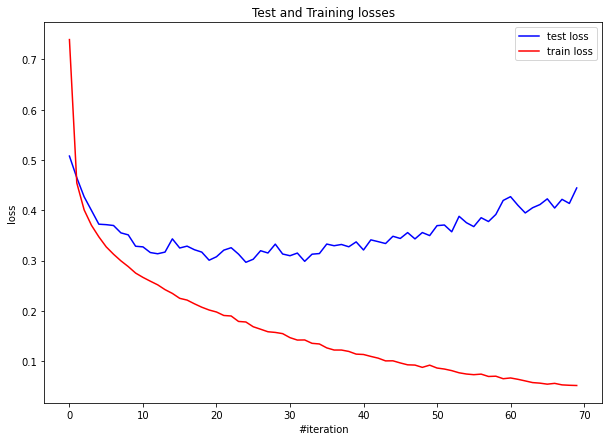

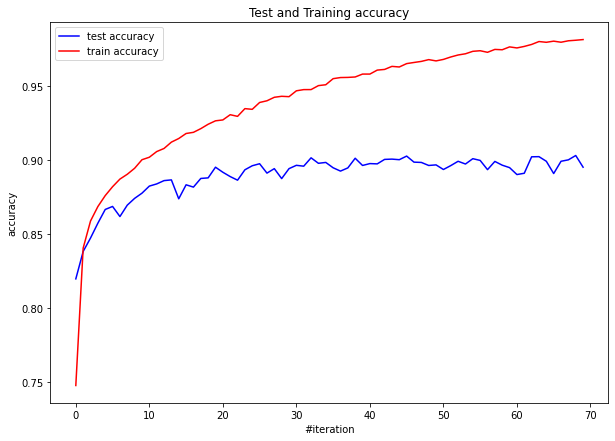

In [18]:
# Main training / testing loop 
for epoch in range(epochs):

  # Training
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    opt.zero_grad()
    model_out = model(data).to(device)
    train_accuracy += (torch.eq(target, torch.argmax(model_out, -1)).float().mean())
    loss = loss_func(model_out, target)
    train_loss += loss.mean().detach().cpu().numpy()
    loss.backward()
    opt.step()

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)] tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                          100. * batch_idx / len(train_loader), loss.data))
  
  train_accuracy /= len(train_loader)
  train_loss /= len(train_loader)
  train_loss_history.append(train_loss)
  train_acc_history.append(train_accuracy)
  
  # Testing 
  test_params = test(model, loss_func)
  test_accuracy = test_params['acc']
  test_loss = test_params['loss']
  test_loss_history.append(test_loss)
  test_acc_history.append(test_accuracy)
  
  pretty_print(train_accuracy, test_accuracy, train_loss, test_loss)

  train_accuracy = 0 
  test_accuracy = 0

plot_losses(train_loss_history, test_loss_history)
plot_accuracy(train_acc_history, test_acc_history) 

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [30]:
class FixedNeuralNetwork(nn.Module):
  def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
      super(self.__class__, self).__init__()
      some_big_const = 1500
      self.model = nn.Sequential(
          nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
          nn.Linear(input_shape, some_big_const), 
          nn.ReLU(), 
          nn.Dropout(),
          nn.Linear(some_big_const, some_big_const), 
          nn.ReLU(), 
          nn.Dropout(),
          nn.Linear(some_big_const, num_classes)
      )
      
  def forward(self, inp):       
      return self.model(inp)


In [31]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1500]       1,177,500
              ReLU-3                 [-1, 1500]               0
           Dropout-4                 [-1, 1500]               0
            Linear-5                 [-1, 1500]       2,251,500
              ReLU-6                 [-1, 1500]               0
           Dropout-7                 [-1, 1500]               0
            Linear-8                   [-1, 10]          15,010
Total params: 3,444,010
Trainable params: 3,444,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 13.14
Estimated Total Size (MB): 13.22
----------------------------------------------------------------


In [32]:
model = FixedNeuralNetwork().to(device)

# Setting some training parameters
learning_rate = 1e-2
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

epochs = 70
log_interval=100
train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []
train_accuracy = 0
train_loss = 0

Train Epoch: 0 [0/60000 (0%)] tLoss: 2.303007
Train Epoch: 0 [12800/60000 (21%)] tLoss: 0.822075
Train Epoch: 0 [25600/60000 (43%)] tLoss: 0.754109
Train Epoch: 0 [38400/60000 (64%)] tLoss: 0.653189
Train Epoch: 0 [51200/60000 (85%)] tLoss: 0.515080
Train accuracy: 0.714885413646698
Test accuracy: 0.8003906607627869
Train loss: 0.8112258229301428
Test loss: 0.54603081792593
Train Epoch: 1 [0/60000 (0%)] tLoss: 0.502046
Train Epoch: 1 [12800/60000 (21%)] tLoss: 0.559230
Train Epoch: 1 [25600/60000 (43%)] tLoss: 0.455872
Train Epoch: 1 [38400/60000 (64%)] tLoss: 0.409862
Train Epoch: 1 [51200/60000 (85%)] tLoss: 0.434052
Train accuracy: 0.8253376483917236
Test accuracy: 0.816210925579071
Train loss: 0.49211867695120054
Test loss: 0.49009253941476344
Train Epoch: 2 [0/60000 (0%)] tLoss: 0.567939
Train Epoch: 2 [12800/60000 (21%)] tLoss: 0.393393
Train Epoch: 2 [25600/60000 (43%)] tLoss: 0.447414
Train Epoch: 2 [38400/60000 (64%)] tLoss: 0.487181
Train Epoch: 2 [51200/60000 (85%)] tLoss: 0

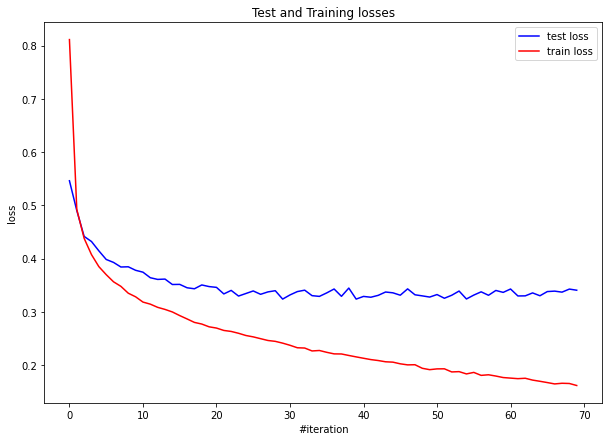

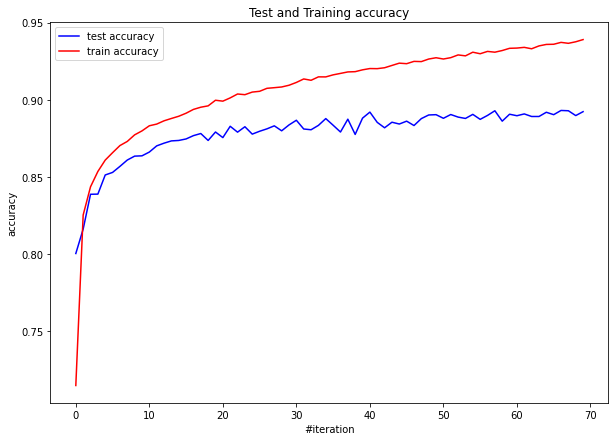

In [33]:
# Main training / testing loop 
for epoch in range(epochs):

  # Training
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    opt.zero_grad()
    model_out = model(data).to(device)
    train_accuracy += (torch.eq(target, torch.argmax(model_out, -1)).float().mean())
    loss = loss_func(model_out, target)
    train_loss += loss.mean().detach().cpu().numpy()
    loss.backward()
    opt.step()

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)] tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                          100. * batch_idx / len(train_loader), loss.data))
  
  train_accuracy /= len(train_loader)
  train_loss /= len(train_loader)
  train_loss_history.append(train_loss)
  train_acc_history.append(train_accuracy)
  
  # Testing 
  test_params = test(model, loss_func)
  test_accuracy = test_params['acc']
  test_loss = test_params['loss']
  test_loss_history.append(test_loss)
  test_acc_history.append(test_accuracy)
  
  pretty_print(train_accuracy, test_accuracy, train_loss, test_loss)

  train_accuracy = 0 
  test_accuracy = 0

plot_losses(train_loss_history, test_loss_history)
plot_accuracy(train_acc_history, test_acc_history) 

### **Conclusions and notes:**
(Conclusions are something I can explain. Notes are something I can't) 

#### **Conclusions**: 
We managed to achieve overfitting by adding wider layers and increasing number of epochs.

> Indented block


We also managed to fix it by adding dropout layers. 

#### **Notes**: 
The third model does not seem to be any better than the first model (with smaller linear layers and no dropouts).

All the noticeable improvement in loss / accuracy happens during the first 15, maybe 20 epochs. After that both train loss and train accuracy are almost constant.

For some reason, batch normalization significantly **enhances** the overfitting (this is why it's not used in the Part 3). (Maybe I just was doing something wrong) 

Linear models are not really good. (I was trying hard to achieve something better than ~0.89 accuracy but I couldn't) 
Or, again, maybe I just was doing something wrong.







